## Correct batch effect

Scgen batch correction.

- **INPUT:**
    -  ```counts_norm.mtx``` 
    -  ```anno_cells_norm.txt``` 
    -  ```anno_samples_norm.txt``` 
    -  ```anno_genes_norm.txt``` 
    -  ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **OUTPUT:**

    -  ```counts_corr.csv.gz``` 
    -  ```anno_cells_corr.txt``` 
    -  ```anno_samples_corr.txt``` 
    -  ```anno_genes_corr.txt``` 
    -  ```adata_afterCorrection.h5ad```

### load data

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import numba as nb
import matplotlib.cm as cm

In [2]:
# read in count table and create an adata object
adata_beforeCorrection = sc.read_mtx("./pdata/counts_norm.mtx",'float64').T

In [3]:
# read in cell annotation file
anno_cells = pd.read_csv("./pdata/anno_cells_norm.txt", sep = "\t") 

In [4]:
# read in sample annotation file
anno_samples = pd.read_csv("./pdata/anno_samples_norm.txt", sep = "\t") 

In [5]:
# read in gene annotation file
anno_genes = pd.read_csv("./pdata/anno_genes_norm.txt", sep = "\t") 

In [6]:
# load cell subtype and color keys
cell_relabel=pd.read_csv("./rdata/cell_relabelling.csv",sep=';')

### process data

In [7]:
adata_beforeCorrection.var_names=anno_genes['gene_symbol']
print("adata_beforeCorrection.var_names[1:10]")
print(adata_beforeCorrection.var_names[1:10])
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)

adata_beforeCorrection.var_names[1:10]
Index(['A1CF', 'A2M', 'A4GALT', 'AAAS', 'AACS', 'AAED1', 'AAGAB', 'AAK1',
       'AAMDC'],
      dtype='object', name='gene_symbol')


In [8]:
adata_beforeCorrection.obs_names=anno_cells['cell_ID']
print("adata_beforeCorrection.obs_names[1:10]")
print(adata_beforeCorrection.obs_names[1:10])
adata_beforeCorrection.obs = anno_cells
adata_beforeCorrection.obs.index = adata_beforeCorrection.obs.index.astype(str)

adata_beforeCorrection.obs_names[1:10]
Index(['N13.LPA.AACCTTACTGCTTT', 'N13.LPA.ACAATCCTCTGAAC',
       'N13.LPA.AGTGACTGGATACC', 'N13.LPA.ATAGATACTGAGCT',
       'N13.LPA.CCCAACACGGTATC', 'N13.LPA.CGGAGGCTTCCTTA',
       'N13.LPA.TAAACAACTTACTC', 'N13.LPA.TACTGTTGCGTAAC',
       'N13.LPA.TCGATACTATGGTC'],
      dtype='object', name='cell_ID')


In [9]:
adata_beforeCorrection.obs_region=anno_cells['region']
adata_beforeCorrection.obs_health_status=anno_cells['health_status']

In [10]:
adata_beforeCorrection

AnnData object with n_obs × n_vars = 80911 × 13146
    obs: 'cell_ID', 'cell_type_original', 'tissue_type', 'cell_type', 'region', 'sample_ID', 'health_status', 'total_counts_raw', 'nr_genes', 'counts_upper_threshold', 'counts_lower_threshold', 'genes_lower_threshold', 'counts_upper_filter', 'counts_lower_filter', 'genes_lower_filter', 'counts_vs_genes_filter', 'cell_filter', 'threshold_celltype_size', 'celltype_size_cf', 'celltype_size_filter', 'cell_type_ID', 'total_counts_raw_cf_ctf_gf', 'total_counts_raw_cf_ctf_gf_sf', 'sizeFactor'
    var: 'gene_symbol', 'inDB', 'isLigand', 'isReceptor', 'sum_pseudobulkCellType_expr', 'sum_pseudobulkCellType_expr_threshold', 'sum_pseudobulkCellType_expr_filter'

### prepare for the visualization

In [11]:
# define colors
colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color"]))
print(colors_cell_type)

{'Epithelial': '#CB4335', 'Fibroblasts': '#8E44AD', 'Endothelial': '#5B2C6F', 'Glia': '#C969DF', 'Myeloid': '#F09040', 'Mast': '#FF7300', 'T-cells': '#4F92EE', 'Plasma': '#4FCCEE', 'B-cells': '#4FC384'}


In [12]:
adata_beforeCorrection.obs["cell_type_original"].value_counts()

Plasma                      21399
Follicular                   7671
CD4+ Memory                  7061
CD8+ LP                      4028
CD4+ Activated Fos-hi        3723
CD4+ Activated Fos-lo        3476
Macrophages                  3120
WNT2B+ Fos-lo 1              2817
TA 2                         2268
Tregs                        2266
TA 1                         2068
Cycling TA                   2044
WNT2B+ Fos-hi                1951
Immature Goblet              1461
WNT5B+ 2                     1311
CD69+ Mast                   1098
WNT5B+ 1                      950
DC2                           939
Post-capillary Venules        887
WNT2B+ Fos-lo 2               837
Immature Enterocytes 2        823
Cycling B                     806
Myofibroblasts                768
Endothelial                   687
Inflammatory Fibroblasts      586
Immature Enterocytes 1        495
Secretory TA                  466
GC                            435
Enterocytes                   420
Stem          

In [13]:
# define color schemes
colors_cell_subtype=dict(zip(cell_relabel["cell_type_original"],cell_relabel["cell_type_original_color"]))
print(colors_cell_subtype)

colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color"]))
print(colors_cell_type)

{'Stem': '#CB4335', 'TA 1': '#CB4335', 'TA 2': '#CB4335', 'Cycling TA': '#CB4335', 'Immature Enterocytes 1': '#CB4335', 'Immature Enterocytes 2': '#CB4335', 'Enterocyte Progenitors': '#CB4335', 'Enterocytes': '#CB4335', 'M cells': '#CB4335', 'Best4+ Enterocytes': '#CB4335', 'Secretory TA': '#CB4335', 'Immature Goblet': '#CB4335', 'Goblet': '#CB4335', 'Tuft': '#CB4335', 'Enteroendocrine': '#CB4335', 'WNT2B+ Fos-hi': '#8E44AD', 'WNT2B+ Fos-lo 1': '#8E44AD', 'WNT2B+ Fos-lo 2': '#8E44AD', 'RSPO3+': '#8E44AD', 'WNT5B+ 1': '#8E44AD', 'WNT5B+ 2': '#8E44AD', 'Inflammatory Fibroblasts': '#8E44AD', 'Myofibroblasts': '#8E44AD', 'Endothelial': '#8E44AD', 'Microvascular': '#8E44AD', 'Post-capillary Venules': '#8E44AD', 'Pericytes': '#8E44AD', 'Glia': '#8E44AD', 'Macrophages': '#F09040', 'DC1': '#F09040', 'DC2': '#F09040', 'Inflammatory Monocytes': '#F09040', 'CD69+ Mast': '#F09040', 'CD69- Mast': '#F09040', 'Cycling Monocytes': '#F09040', 'NKs': '#4F92EE', 'ILCs': '#4F92EE', 'CD4+ Activated Fos-hi'

In [14]:
adata_beforeCorrection.uns["region_colors"] = ["#7AC5CD" # bordeau for colitis
                                                     , "#7C001F" # CadetBlue3 for healthy
                                                     , "#FF8B24"
                                                     ]
adata_beforeCorrection.uns["health_status_colors"] = ["red" # bordeau for colitis
                                                     ,"gray" # CadetBlue3 for healthy
                                                     ]

#adata_beforeCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
#                                                  , "#C0392B" # red for TRUE
#                                                 ]

adata_beforeCorrection.uns["sample_ID_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

In [15]:
#print(adata_beforeCorrection.obs['cell_type_original'])
adata_beforeCorrection.obs['cell_type_original'] = adata_beforeCorrection.obs['cell_type_original'].astype('category')

adata_beforeCorrection.obs['cell_type_original'].cat.reorder_categories([
"Stem","TA 1","TA 2","Cycling TA","Immature Enterocytes 1","Immature Enterocytes 2","Enterocyte Progenitors","Enterocytes","M cells","Best4+ Enterocytes","Secretory TA","Immature Goblet","Goblet","Enteroendocrine","WNT2B+ Fos-hi","WNT2B+ Fos-lo 1","WNT2B+ Fos-lo 2","RSPO3+","WNT5B+ 1","WNT5B+ 2","Inflammatory Fibroblasts","Myofibroblasts","Endothelial","Microvascular","Post-capillary Venules","Pericytes","Macrophages","DC1","DC2","Inflammatory Monocytes","CD69+ Mast","CD69- Mast","Cycling Monocytes","NKs","ILCs","CD4+ Activated Fos-hi","CD4+ Activated Fos-lo","CD4+ Memory","Tregs","CD4+ PD1+","CD8+ IELs","CD8+ LP","CD8+ IL17+","MT-hi","Cycling T","Plasma","Follicular","GC","Cycling B","Tuft"], inplace=True)

/tmp/ipykernel_55839/790272164.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_beforeCorrection.obs['cell_type_original'].cat.reorder_categories([


In [16]:
#legend_order = ["Stem","TA 1","TA 2","Cycling TA","Immature Enterocytes 1","Immature Enterocytes 2","Enterocyte Progenitors","Enterocytes","M cells","Best4+ Enterocytes","Secretory TA","Immature Goblet","Goblet","Enteroendocrine","WNT2B+ Fos-hi","WNT2B+ Fos-lo 1","WNT2B+ Fos-lo 2","RSPO3+","WNT5B+ 1","WNT5B+ 2","Inflammatory Fibroblasts","Myofibroblasts","Endothelial","Microvascular","Post-capillary Venules","Pericytes","Glia","Macrophages","DC1","DC2","Inflammatory Monocytes","CD69+ Mast","CD69- Mast","Cycling Monocytes","NKs","ILCs","CD4+ Activated Fos-hi","CD4+ Activated Fos-lo","CD4+ Memory","Tregs","CD4+ PD1+","CD8+ IELs","CD8+ LP","CD8+ IL17+","MT-hi","Cycling T","Plasma","Follicular","GC","Cycling B","Tuft"]
#cat_dtype = pd.CategoricalDtype(categories=legend_order, ordered=True)
#adata_beforeCorrection.obs['cell_type_original'] = adata_beforeCorrection.obs['cell_type_original'].astype(cat_dtype)


In [17]:
cell_types = adata_beforeCorrection.obs['cell_type_original'].unique()

# Generate a list of colors from viridis color map with the same length as cell_types
colors = cm.plasma(np.linspace(0, 1, len(cell_types)))

# Map each cell type to a color in the dictionary
cell_type_original_vir = dict(zip(cell_types, colors))

### visualize before batch correction

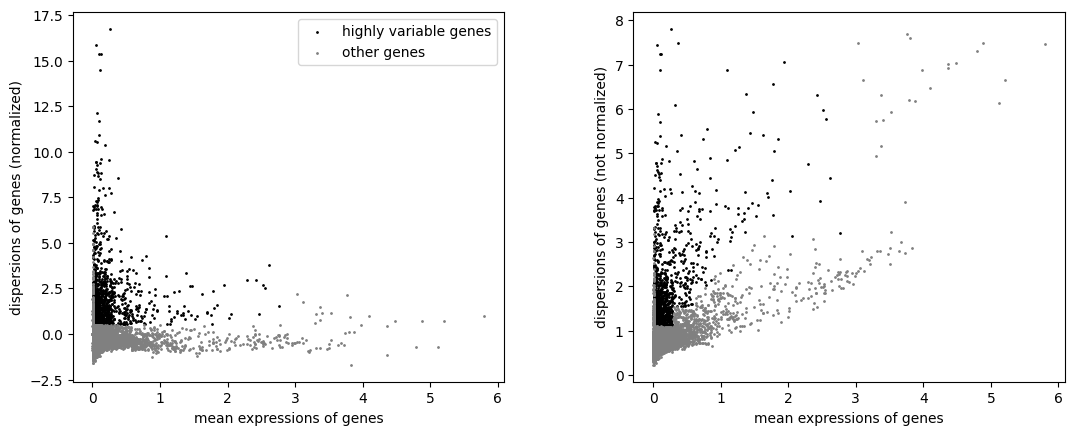

In [18]:
# logtransform before HVG calculation
sc.pp.log1p(adata_beforeCorrection)

sc.pp.highly_variable_genes(adata_beforeCorrection)
sc.pl.highly_variable_genes(adata_beforeCorrection)

In [19]:
# print how many HVGs we have:
print("Nr of HVGs:")
print(sum(adata_beforeCorrection.var.highly_variable))

Nr of HVGs:
1933


In [20]:
sc.tl.pca(adata_beforeCorrection, svd_solver='arpack')

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


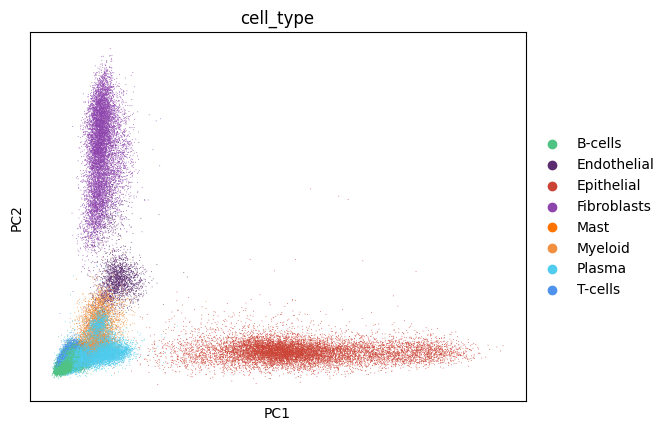

In [21]:
sc.pl.pca(adata_beforeCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
         )

In [22]:
sc.pp.neighbors(adata_beforeCorrection)

/home/fsalcher/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
sc.tl.umap(adata_beforeCorrection)

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


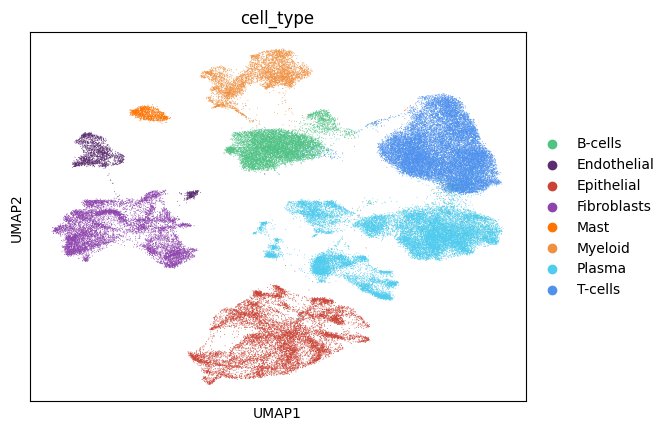

In [24]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type"]
          , palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
          )

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


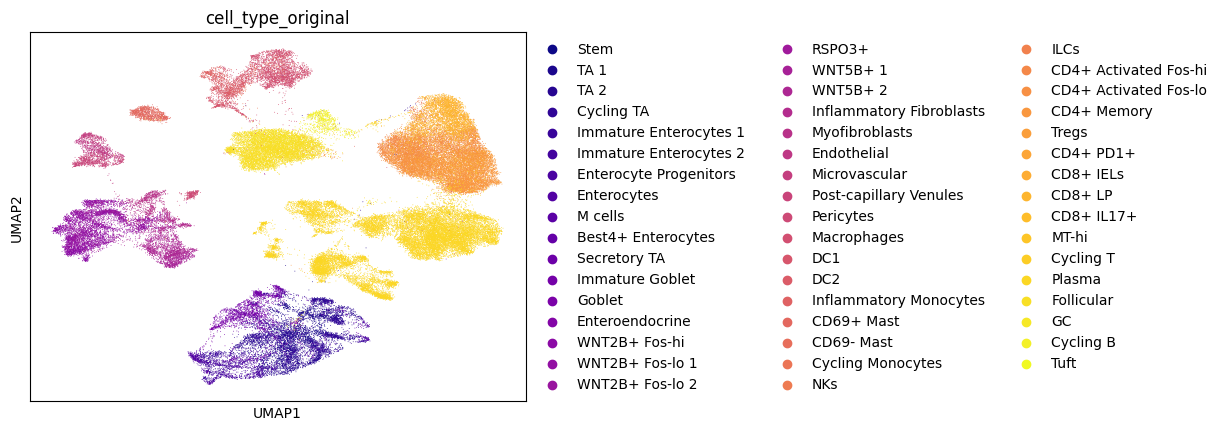

In [25]:
sc.pl.umap(adata_beforeCorrection
          ,color="cell_type_original"
          ,palette=cell_type_original_vir
          ,save="_beforeCorrection_cell_subtype.pdf"
          )

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


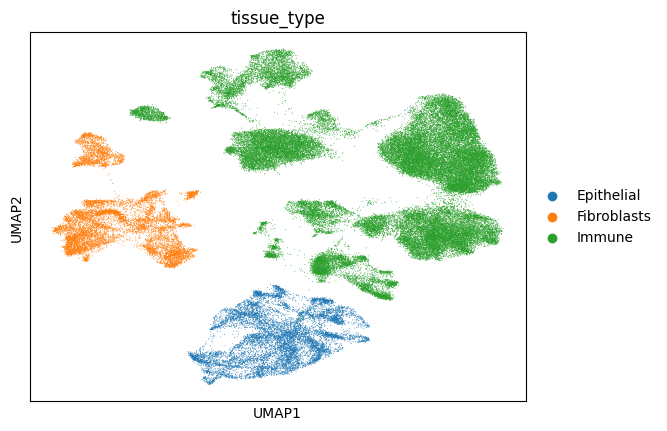

In [26]:
sc.pl.umap(adata_beforeCorrection
           , color=["tissue_type"]
          # , palette="viridis"
          ,save="_beforeCorrection_tissue_type.pdf"
          )

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


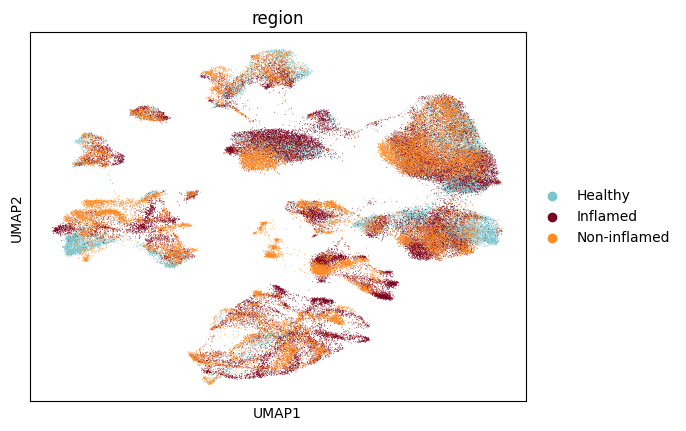

In [27]:
sc.pl.umap(adata_beforeCorrection
           , color=["region"]
          ,save="_beforeCorrection_region.pdf"
          )

/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


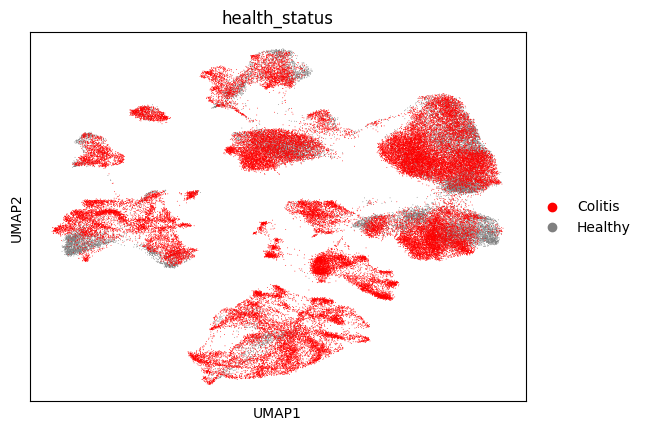

In [28]:
sc.pl.umap(adata_beforeCorrection
           , color=["health_status"]
          ,save="_beforeCorrection_health_status.pdf"
          )

In [29]:
print(adata_beforeCorrection.obs['cell_type_original'].unique())


['Stem', 'TA 1', 'TA 2', 'Cycling TA', 'Immature Enterocytes 1', ..., 'Plasma', 'Follicular', 'GC', 'Cycling B', 'Tuft']
Length: 50
Categories (50, object): ['Stem', 'TA 1', 'TA 2', 'Cycling TA', ..., 'Follicular', 'GC', 'Cycling B', 'Tuft']


/home/fsalcher/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


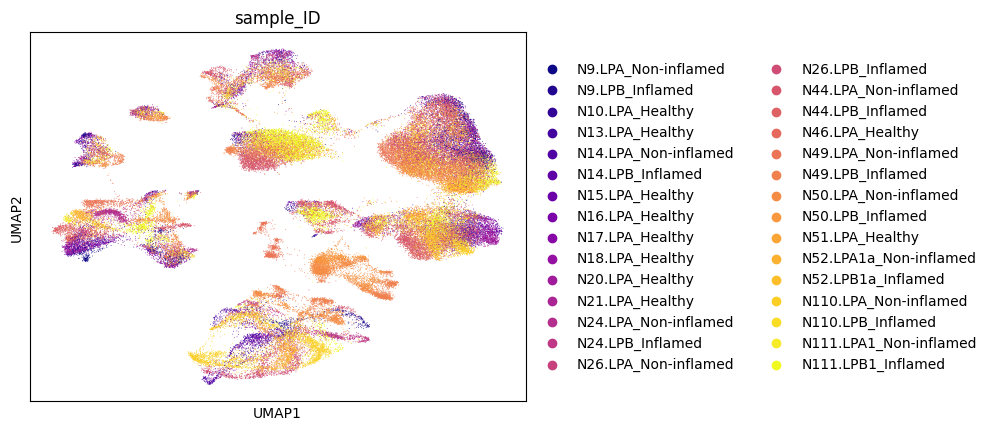

In [30]:
sc.pl.umap(adata_beforeCorrection
           , color=["sample_ID"]
           , palette="plasma"
           ,save="_beforeCorrection_sample_ID.pdf"
          )

In [31]:
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)
adata_beforeCorrection.var_names=anno_genes['gene_symbol']

## Export

In [ ]:
# export counts as csv.gz
#print(adata_beforeCorrection.X.shape)
#print("save counts_corr.csv.gz")

# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=adata_beforeCorrection.to_df().transpose()
counts_corr.index = adata_beforeCorrection.var.gene_symbol
counts_corr.columns = adata_beforeCorrection.obs.cell_ID
counts_corr.to_csv("./pdata/counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

save counts_corr.csv.gz


In [ ]:
# export anno_cells_corr
print("save anno_cells_corr.txt")
adata_beforeCorrection.obs.to_csv("./pdata/anno_cells_corr.txt"
                    ,sep = "\t"
                    ,index = True)


In [ ]:
# export anno_samples_corr
print("save anno_samples_corr.txt")
anno_samples.to_csv("./pdata/anno_samples_corr.txt"
                    ,sep = "\t"
                    ,index = True)

In [ ]:
# export anno_genes_corr
print("save anno_genes_corr.txt")
adata_beforeCorrection.var.to_csv("./pdata/anno_genes_corr.txt"
                    ,sep = "\t"
                    ,index = True)